**Recommender Systems**
Recommender systems help predict what you might like based on your past behavior. There are two types: collaborative filtering (suggests things similar users like) and content-based filtering (suggests things similar to what you've shown interest in). For example, Netflix uses collaborative filtering for movie recommendations, and Pandora uses content-based filtering for music suggestions.

**Collaborative Filtering**
Collaborative filtering is a popular way to recommend things based on what users with similar tastes have liked before. It assumes that if users agreed in the past, they'll agree in the future. Unlike content-based filtering, it doesn't need to understand the details of the items. Instead, it relies on user behavior data to make predictions. Collaborative filtering faces challenges like needing a lot of user data, being computationally demanding, and dealing with sparse datasets. Despite these challenges, it's widely used, and in this chapter, we'll explore how to tackle these issues.

# **Movie Recommender Systems Using Neural Network**

MovieLens Dataset
Instead of the 100 million ratings Netflix dataset, we will use a smaller movie ratings dataset known as the MovieLens 20M Dataset, provided by GroupLens, a research lab in the Department of Computer Science and Engineering at the University of Minnesota, Twin Cities. The data contains 20,000,263 ratings across 27,278 movies created by 138,493 users from January 9, 1995 to March 31, 2015. Of users who rated at least 20 movies each, we will select a subset at random. This dataset is more manageable to work with than the 100 million ratings dataset from Netflix. Because the file size exceeds one hundred megabytes, the file is not accessible on GitHub. You will need to download the file directly from the MovieLens website.

In [ ]:
import numpy as np
import pandas as pd
import os, time, re
import pickle, gzip, datetime

from datetime import datetime

now = datetime.now()

import matplotlib.pyplot as plt
import seaborn as sns
color = sns.color_palette()
import matplotlib as mpl
%matplotlib inline


from sklearn import preprocessing as pp
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import log_loss
from sklearn.metrics import precision_recall_curve, average_precision_score
from sklearn.metrics import roc_curve, auc, roc_auc_score, mean_squared_error
import lightgbm as lgb


import tensorflow as tf
import keras

from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Activation, Dense, Dropout
from tensorflow.keras.layers import BatchNormalization, Input, Lambda
from tensorflow.keras.layers import Embedding, Flatten, dot
from tensorflow.keras import regularizers
from tensorflow.keras.losses import mse, binary_crossentropy

# Load the data

In [ ]:
# Install wget (if not already installed)
!pip install wget

# Import wget library
import wget

# URL of the MovieLens 100K dataset
url = "https://files.grouplens.org/datasets/movielens/ml-100k.zip"

# Define the location where you want to save the dataset
save_path = "/content/ml-100k.zip"

# Use wget to download the dataset
wget.download(url, save_path)

# Unzip the downloaded file
import zipfile
with zipfile.ZipFile(save_path, "r") as zip_ref:
    zip_ref.extractall("/content/")

# Display the contents of the extracted directory
extracted_directory = "/content/ml-100k/"
print("\nContents of the extracted directory:")
!ls $extracted_directory

  Preparing metadata (setup.py) ... done
  Created wheel for wget: filename=wget-3.2-py3-none-any.whl size=9655 sha256=42214107da9236429f3521750e9494cfc45efc7214ddfe3772a249c0bd229776
  Stored in directory: /root/.cache/pip/wheels/8b/f1/7f/5c94f0a7a505ca1c81cd1d9208ae2064675d97582078e6c769
Successfully built wget

Contents of the extracted directory:
allbut.pl  u1.base  u2.test  u4.base  u5.test  ub.base	u.genre  u.occupation
mku.sh	   u1.test  u3.base  u4.test  ua.base  ub.test	u.info	 u.user
README	   u2.base  u3.test  u5.base  ua.test  u.data	u.item


In [ ]:
# Importing libraries
import pandas as pd
import numpy as np

# Define the path to the MovieLens 100K dataset in your Colab environment
base_path = "/content/ml-100k/"

# Reading users file
#It reads the u.user file, which contains information about users such as user ID, age, sex, occupation, and zip code. The data is read using the specified column names and delimiter (|).
u_cols = ['user_id', 'age', 'sex', 'occupation', 'zip_code']
users = pd.read_csv(base_path + 'u.user', sep='|', names=u_cols, encoding='latin-1')

# Reading ratings file
#It reads the u.data file, which contains user ratings for movies. The columns include user ID, movie ID, rating, and a timestamp. The data is read using the specified column names and tab (\t) as the separator.
r_cols = ['user_id', 'movie_id', 'rating', 'unix_timestamp']
ratings = pd.read_csv(base_path + 'u.data', sep='\t', names=r_cols, encoding='latin-1')

# Reading items file
#It reads the u.item file, which contains information about movies, such as movie ID, title, release date, and genre information. The data is read using the specified column names and delimiter (|).
i_cols = ['movie_id', 'movie_title', 'release_date', 'video_release_date', 'IMDb_URL', 'unknown', 'Action', 'Adventure',
          'Animation', 'Children\'s', 'Comedy', 'Crime', 'Documentary', 'Drama', 'Fantasy', 'Film-Noir', 'Horror',
          'Musical', 'Mystery', 'Romance', 'Sci-Fi', 'Thriller', 'War', 'Western']
items = pd.read_csv(base_path + 'u.item', sep='|', names=i_cols, encoding='latin-1')

# Displaying the content of each file
#It displays the shape (number of rows and columns) and the first few rows of each dataset (User Data, Ratings Data, and Item Data) using the shape and head() functions.
# User Data
print("\nUser Data:")
print("Shape: ", users.shape)
print(users.head())

## We have 943 users in the dataset and each user has 5 features, i.e. user_ID, age, sex, occupation and zip_code.
#Now let’s look at the ratings file.

# Ratings Data
print("\nRatings Data:")
print("Shape: ", ratings.shape)
print(ratings.head())

## We have 100k ratings for different user and movie combinations. Now finally examine the items file.

# Item Data
print("\nItem Data:")
print("Shape: ", items.shape)
print(items.head())



User Data:
Shape:  (943, 5)
   user_id  age sex  occupation zip_code
0        1   24   M  technician    85711
1        2   53   F       other    94043
2        3   23   M      writer    32067
3        4   24   M  technician    43537
4        5   33   F       other    15213

Ratings Data:
Shape:  (100000, 4)
   user_id  movie_id  rating  unix_timestamp
0      196       242       3       881250949
1      186       302       3       891717742
2       22       377       1       878887116
3      244        51       2       880606923
4      166       346       1       886397596

Item Data:
Shape:  (1682, 24)
   movie_id        movie_title release_date  video_release_date  \
0         1   Toy Story (1995)  01-Jan-1995                 NaN   
1         2   GoldenEye (1995)  01-Jan-1995                 NaN   
2         3  Four Rooms (1995)  01-Jan-1995                 NaN   
3         4  Get Shorty (1995)  01-Jan-1995                 NaN   
4         5     Copycat (1995)  01-Jan-1995           

# Data Preprocessing:

In [ ]:
# Modify the ratings DataFrame
ratings['user_id'] = ratings['user_id'].astype(str).astype(int)
ratings['movie_id'] = ratings['movie_id'].astype(str).astype(int)
ratings['rating'] = ratings['rating'].astype(str).astype(float)
ratings['unix_timestamp'] = pd.to_datetime(ratings['unix_timestamp'], unit='s').apply(lambda x: x.strftime("%m/%d/%Y, %H:%M:%S"))

# Display the modified Ratings Data
print("\nModified Ratings Data:")
print("Shape: ", ratings.shape)
print(ratings.head())


Modified Ratings Data:
Shape:  (100000, 4)
   user_id  movie_id  rating        unix_timestamp
0      196       242     3.0  12/04/1997, 15:55:49
1      186       302     3.0  04/04/1998, 19:22:22
2       22       377     1.0  11/07/1997, 07:18:36
3      244        51     2.0  11/27/1997, 05:02:03
4      166       346     1.0  02/02/1998, 05:33:16


# Exploratory Data Analysis (EDA):

In [ ]:
n_users = ratings['user_id'].nunique()
n_movies = ratings['movie_id'].nunique()
n_ratings = len(ratings)
avg_ratings_per_user = n_ratings / n_users

print('Number of unique users: ', n_users)
print('Number of unique movies: ', n_movies)
print('Number of total ratings: ', n_ratings)
print('Average number of ratings per user: ', avg_ratings_per_user)

Number of unique users:  943
Number of unique movies:  1682
Number of total ratings:  100000
Average number of ratings per user:  106.04453870625663


In [ ]:
movieIndex = ratings.groupby("movie_id").count().sort_values(by="rating", ascending=False).head(1000).index #Finds the top 1000 movies with the most ratings in the original dataset (ratings).The result is an index (a list of movie IDs) for these top movies.
ratingDFX2 = ratings[ratings.movie_id.isin(movieIndex)] #Creates a new DataFrame (ratingDFX2) containing only the rows from the original dataset where the movie ID is in the movieIndex.This effectively filters the original dataset to include only the most popular 1000 movies.
print(ratingDFX2.count())

user_id           96056
movie_id          96056
rating            96056
unix_timestamp    96056
dtype: int64


In [ ]:
userIndex = ratingDFX2.groupby("user_id").count().sort_values(by="rating", ascending=False)#Finds the top 1000 users who have rated movies in the ratingDFX2 dataset.This is done by grouping the dataset by user ID, counting the number of ratings for each user, sorting in descending order, and then randomly selecting 1000 users (or all users if there are fewer than 1000).
userIndex = userIndex.sample(n=min(1000, len(userIndex)), random_state=2018).index
ratingDFX3 = ratingDFX2[ratingDFX2.user_id.isin(userIndex)] #Creates another DataFrame (ratingDFX3) containing only the rows from ratingDFX2 where the user ID is in the userIndex.This narrows down the dataset to include ratings from the most active 1000 users who have rated the most popular 1000 movies.
print(ratingDFX3.count())

user_id           96056
movie_id          96056
rating            96056
unix_timestamp    96056
dtype: int64


Let’s also reindex movieID and userID to a range of 1 to 1,000 for our reduced dataset:

In [ ]:
movies = ratingDFX3['movie_id'].unique() #Extracts unique movie IDs from the ratingDFX3 dataset.
moviesDF = pd.DataFrame(data=movies, columns=['originalMovieId'])
moviesDF['newMovieId'] = moviesDF.index + 1 #Creates a new DataFrame (moviesDF) with two columns: 'originalMovieId' (containing unique movie IDs) and 'newMovieId' (a sequential index starting from 1).

# Display the modified DataFrame
print(moviesDF.head())

   originalMovieId  newMovieId
0              242           1
1              302           2
2               51           3
3              346           4
4              474           5


In [ ]:
users = ratingDFX3['user_id'].unique()
usersDF = pd.DataFrame(data=users, columns=['originalUserId'])
usersDF['newUserId'] = usersDF.index + 1

# Display the modified DataFrame
print(usersDF.head())

   originalUserId  newUserId
0             196          1
1             186          2
2             244          3
3             166          4
4             298          5


In [ ]:
ratingDFX3 = ratingDFX3.merge(moviesDF, left_on='movie_id', right_on='originalMovieId') #Merges the ratingDFX3 DataFrame with the moviesDF DataFrame on the 'movie_id' and 'originalMovieId' columns, respectively.
ratingDFX3.drop(labels='originalMovieId', axis=1, inplace=True)#Drops the 'originalMovieId' column from the merged DataFrame.

ratingDFX3 = ratingDFX3.merge(usersDF, left_on='user_id', right_on='originalUserId')#Merges the previously merged DataFrame with the usersDF DataFrame on the 'user_id' and 'originalUserId' columns, respectively.
ratingDFX3.drop(labels='originalUserId', axis=1, inplace=True)#Drops the 'originalUserId' column from the final merged DataFrame.

# Display the modified DataFrame
print(ratingDFX3.head())

   user_id  movie_id  rating        unix_timestamp  newMovieId  newUserId
0      196       242     3.0  12/04/1997, 15:55:49           1          1
1      196       257     2.0  12/04/1997, 16:06:17          10          1
2      196       111     4.0  12/04/1997, 16:09:53          81          1
3      196        25     4.0  12/04/1997, 16:12:35          84          1
4      196       382     4.0  12/04/1997, 16:10:43          90          1


Let’s calculate the number of unique users, unique movies, total ratings, and average number of ratings per user for our reduced dataset:

In [ ]:
n_users = ratingDFX3['user_id'].nunique()
n_movies = ratingDFX3['movie_id'].nunique()
n_ratings = len(ratingDFX3)
avg_ratings_per_user = n_ratings / n_users

print('Number of unique users: ', n_users)
print('Number of unique movies: ', n_movies)
print('Number of total ratings: ', n_ratings)
print('Average number of ratings per user: ', avg_ratings_per_user)

Number of unique users:  943
Number of unique movies:  1000
Number of total ratings:  96056
Average number of ratings per user:  101.86214209968186


Let’s generate a test set and a validation set from this reduced dataset so that each holdout set is 5% of the reduced dataset:

# Train-Test Split:

In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_test = train_test_split(ratingDFX3, test_size=0.10, shuffle=True, random_state=2018)
X_validation, X_test = train_test_split(X_test, test_size=0.50, shuffle=True, random_state=2018)

print('Shape of train set:', X_train.shape)
print('Shape of validation set:', X_validation.shape)
print('Shape of test set: ', X_test.shape)

print('Size of train set:', X_train.size)
print('Size of validation set:', X_validation.size)
print('Size of test set: ', X_test.size)


Shape of train set: (86450, 6)
Shape of validation set: (4803, 6)
Shape of test set:  (4803, 6)
Size of train set: 518700
Size of validation set: 28818
Size of test set:  28818


Define the Cost Function: Mean Squared Error

This code is part of the process of preparing the user-item interaction matrices for training, validation, and test sets. Let me break down what each part of the code does:

Training Set (ratings_train):

ratings_train = np.zeros((n_users, n_movies)): Initializes a matrix of zeros with dimensions (number of users) x (number of movies).
for row in X_train.itertuples():: Iterates over each row in the training set.
ratings_train[int(row[6]) - 1, int(row[5]) - 1] = float(row[3]): Assigns the rating (converted to float) from the training set to the corresponding position in the ratings_train matrix. The row[6] is the user index, row[5] is the movie index, and row[3] is the rating.
Sparsity Calculation for Training Set:

sparsity_train = float(len(ratings_train.nonzero()[0])): Calculates the number of non-zero elements in the ratings_train matrix (i.e., the number of rated items).
sparsity_train /= (ratings_train.shape[0] * ratings_train.shape[1]): Divides the number of non-zero elements by the total number of elements in the matrix to get the sparsity as a percentage.
print('Sparsity for train set: {:4.2f}%'.format(sparsity_train)): Prints the sparsity percentage for the training set.

Validation Set (ratings_validation):

ratings_validation = np.zeros((n_users, n_movies)): Initializes a similar matrix for the validation set.
for row in X_validation.itertuples():: Iterates over each row in the validation set.
ratings_validation[int(row[6]) - 1, int(row[5]) - 1] = float(row[3]): Assigns the rating (converted to float) from the validation set to the corresponding position in the ratings_validation matrix.
Test Set (ratings_test):

ratings_test = np.zeros((n_users, n_movies)): Initializes a similar matrix for the test set.
for row in X_test.itertuples():: Iterates over each row in the test set.
ratings_test[int(row[6]) - 1, int(row[5]) - 1] = float(row[3]): Assigns the rating (converted to float) from the test set to the corresponding position in the ratings_test matrix.

In [ ]:
# Convert the 'rating' column to float before assigning to the ratings matrix
ratings_train = np.zeros((n_users, n_movies))
for row in X_train.itertuples():
    ratings_train[int(row[6]) - 1, int(row[5]) - 1] = float(row[3])

sparsity_train = float(len(ratings_train.nonzero()[0]))
sparsity_train /= (ratings_train.shape[0] * ratings_train.shape[1])
sparsity_train *= 100
print('Sparsity for train set: {:4.2f}%'.format(sparsity_train))

Sparsity for train set: 9.17%


In [ ]:
# Convert the 'rating' column to float for validation set
ratings_validation = np.zeros((n_users, n_movies))
for row in X_validation.itertuples():
    ratings_validation[int(row[6]) - 1, int(row[5]) - 1] = float(row[3])

# Convert the 'rating' column to float for test set
ratings_test = np.zeros((n_users, n_movies))
for row in X_test.itertuples():
    ratings_test[int(row[6]) - 1, int(row[5]) - 1] = float(row[3])

Perform Baseline Experiments: Predicting ratings and Evaluating the performance using Mean Squared Error (MSE).

#Initialize Predictions for Validation Set

In [ ]:
pred_validation = np.zeros((len(X_validation),1)) #Initializes an array pred_validation with zeros.
pred_validation[pred_validation==0] = 3.5 #Sets all zero elements in the array to a constant value (3.5 in this case). This step is essentially making a constant prediction for all items in the validation set.
pred_validation

array([[3.5],
       [3.5],
       [3.5],
       ...,
       [3.5],
       [3.5],
       [3.5]])

Calculate Mean Squared Error for Constant Prediction:

In [ ]:
actual_validation = ratings_validation[ratings_validation.nonzero()].flatten()
print("Mean Squared Error is : ", mean_squared_error(pred_validation, actual_validation))

Mean Squared Error is :  1.2318863210493443


User Average Prediction:

In [ ]:
#Initializes a matrix (ratings_validation_prediction) with zeros for user average prediction.
#Computes the mean of each user's ratings (excluding zeros) from the training set and fills the corresponding rows in the prediction matrix.
#Calculates and prints the MSE between user average predictions and actual ratings.

ratings_validation_prediction = np.zeros((n_users, n_movies))
i = 0
for row in ratings_train:
    ratings_validation_prediction[i][ratings_validation_prediction[i] == 0] = np.mean(row[row > 0])
    i += 1
pred_validation = ratings_validation_prediction[ratings_validation.nonzero()].flatten()
user_average = mean_squared_error(pred_validation, actual_validation)
print('Mean squared error using user average:', user_average)


Mean squared error using user average: 1.0707166841893025


Movie Average Prediction:

In [ ]:
#Initializes a transposed matrix (ratings_validation_prediction) with zeros for movie average prediction.
#Computes the mean of each movie's ratings (excluding zeros) from the training set and fills the corresponding columns in the transposed prediction matrix.
#Transposes the matrix back and calculates the MSE between movie average predictions and actual ratings.


ratings_validation_prediction = np.zeros((n_users, n_movies)).T
i = 0
for row in ratings_train.T:
    ratings_validation_prediction[i][ratings_validation_prediction[i] == 0] = np.mean(row[row > 0])
    i += 1
ratings_validation_prediction = ratings_validation_prediction.T
pred_validation = ratings_validation_prediction[ratings_validation.nonzero()].flatten()
movie_average = mean_squared_error(pred_validation, actual_validation)
print('Mean squared error using movie average:', movie_average)

Mean squared error using movie average: 1.003151856045601


Matrix Factorization: In this step, you are creating a collaborative filtering model using matrix factorization.

In the context of recommendation systems, we often have a matrix representing the interactions between users and items. Each entry in the matrix corresponds to a user's rating (or some form of interaction) for a particular item.

Matrix factorization aims to decompose this matrix into two lower-dimensional matrices: one representing users and the other representing items. These matrices are called user and item embeddings.

Input: Defines input layers for users and movies. Each input represents a user or a movie.

Embedding: These layers are like lookup tables that transform user and movie IDs into dense vectors (embeddings). The input_dim is the number of unique users or movies, and output_dim is the dimensionality of the embedding space.

Flatten: Converts the output of the embedding layers into flat vectors. This is necessary for subsequent operations.

Dot Product Layer:
dot: Performs the dot product of the user and movie vectors. This operation is a key part of collaborative filtering, as it captures the interaction between users and items.


In [ ]:
from keras.models import Model
from keras.layers import Input, Embedding, Flatten, dot, BatchNormalization
from keras.regularizers import l2
from keras.optimizers import Adam, RMSprop

n_latent_factors = 10

# Define input layers
user_input = Input(shape=[1], name='user')
movie_input = Input(shape=[1], name='movie')

# Embedding layers with regularization
user_embedding = Embedding(input_dim=n_users + 1, output_dim=n_latent_factors, name='user_embedding', embeddings_regularizer=l2(1e-5))(user_input)
movie_embedding = Embedding(input_dim=n_movies + 1, output_dim=n_latent_factors, name='movie_embedding', embeddings_regularizer=l2(1e-5))(movie_input)

# Flatten embeddings
user_vec = Flatten(name='flatten_users')(user_embedding)
movie_vec = Flatten(name='flatten_movies')(movie_embedding)

# Batch normalization
user_vec_normalized = BatchNormalization()(user_vec)
movie_vec_normalized = BatchNormalization()(movie_vec)

# Dot product to calculate product
product = dot([movie_vec_normalized, user_vec_normalized], axes=1)

# Define the model
model = Model(inputs=[user_input, movie_input], outputs=product)

from keras.callbacks import ReduceLROnPlateau

# Define a learning rate scheduler
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=0.0001)


# Compile the model with Adam optimizer and mean squared error loss
model.compile(optimizer=Adam(learning_rate=0.001), loss='mean_squared_error')

Training a collaborative filtering model using matrix factorization with embeddings.

In [ ]:
# Train the model with the learning rate scheduler
history = model.fit(
    x=[X_train.newUserId, X_train.newMovieId],
    y=X_train.rating,
    epochs=50,
    validation_data=([X_validation.newUserId, X_validation.newMovieId], X_validation.rating),
    callbacks=[reduce_lr],  # Add the learning rate scheduler
    verbose=1
)

Epoch 1/50
2702/2702 [==============================] - 18s 5ms/step - loss: 2.9986 - val_loss: 0.9635 - lr: 0.0010
Epoch 2/50
2702/2702 [==============================] - 14s 5ms/step - loss: 0.9161 - val_loss: 0.9085 - lr: 0.0010
Epoch 3/50
2702/2702 [==============================] - 14s 5ms/step - loss: 0.8864 - val_loss: 0.8567 - lr: 0.0010
Epoch 4/50
2702/2702 [==============================] - 15s 5ms/step - loss: 0.8593 - val_loss: 0.8430 - lr: 0.0010
Epoch 5/50
2702/2702 [==============================] - 15s 5ms/step - loss: 0.8378 - val_loss: 0.8376 - lr: 0.0010
Epoch 6/50
2702/2702 [==============================] - 14s 5ms/step - loss: 0.8247 - val_loss: 0.8362 - lr: 0.0010
Epoch 7/50
2702/2702 [==============================] - 14s 5ms/step - loss: 0.8166 - val_loss: 0.8323 - lr: 0.0010
Epoch 8/50
2702/2702 [==============================] - 14s 5ms/step - loss: 0.8038 - val_loss: 0.8324 - lr: 0.0010
Epoch 9/50
2702/2702 [==============================] - 13s 5ms/step - l

Minimum MSE:  0.8322848677635193


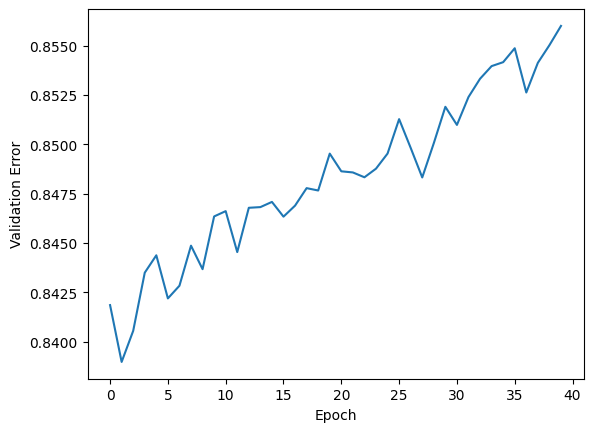

In [ ]:
pd.Series(history.history['val_loss'][10:]).plot(logy=False)
plt.xlabel("Epoch")
plt.ylabel("Validation Error")
print('Minimum MSE: ', min(history.history['val_loss'])) #Prints the minimum validation MSE (Mean Squared Error) achieved during the training.

In [ ]:
# Assuming you have X_test with columns 'newUserId' and 'newMovieId' for your test set
predictions = model.predict([X_test.newUserId.head(10), X_test.newMovieId.head(10)])

# Display predicted values and actual ratings for the first 10 rows
for i in range(10):
    print("Predicted Rating:", predictions[i][0], "Actual Rating:", X_test.rating.iloc[i])

1/1 [==============================] - 0s 98ms/step
Predicted Rating: 1.7429075 Actual Rating: 2.0
Predicted Rating: 3.561973 Actual Rating: 4.0
Predicted Rating: 2.5494084 Actual Rating: 3.0
Predicted Rating: 4.5297737 Actual Rating: 5.0
Predicted Rating: 2.6139503 Actual Rating: 3.0
Predicted Rating: 2.8416045 Actual Rating: 2.0
Predicted Rating: 3.13042 Actual Rating: 3.0
Predicted Rating: 4.2009306 Actual Rating: 5.0
Predicted Rating: 2.9034264 Actual Rating: 2.0
Predicted Rating: 2.9374356 Actual Rating: 4.0


In [ ]:
for epoch in range(len(history.history['loss'])):
    print(f"Epoch {epoch + 1} - Training MSE: {history.history['loss'][epoch]}, Validation MSE: {history.history['val_loss'][epoch]}")

Epoch 1 - Training MSE: 2.9986412525177, Validation MSE: 0.9635104537010193
Epoch 2 - Training MSE: 0.916069507598877, Validation MSE: 0.9085275530815125
Epoch 3 - Training MSE: 0.8864465355873108, Validation MSE: 0.8567409515380859
Epoch 4 - Training MSE: 0.8592609763145447, Validation MSE: 0.8429956436157227
Epoch 5 - Training MSE: 0.8377684950828552, Validation MSE: 0.8376321196556091
Epoch 6 - Training MSE: 0.8247496485710144, Validation MSE: 0.8361886739730835
Epoch 7 - Training MSE: 0.816638708114624, Validation MSE: 0.8322848677635193
Epoch 8 - Training MSE: 0.803838849067688, Validation MSE: 0.8323739767074585
Epoch 9 - Training MSE: 0.7961752414703369, Validation MSE: 0.8344066739082336
Epoch 10 - Training MSE: 0.7865866422653198, Validation MSE: 0.8333720564842224
Epoch 11 - Training MSE: 0.7746322154998779, Validation MSE: 0.8418495059013367
Epoch 12 - Training MSE: 0.7728431224822998, Validation MSE: 0.8389699459075928
Epoch 13 - Training MSE: 0.7359959483146667, Validation